In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, make_scorer
import scipy.stats as ss
from tqdm import tqdm

In [2]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [3]:
summary = pd.read_csv('../data/summary.csv')

summary_df = summary.sort_values(['day', 'assessment_end_time']).reset_index(drop=True)

In [4]:
summary_train_df = summary_df[summary_df['day'] <= 45]

In [5]:
summary_train_df.head()

Unnamed: 0  arrival_time  assessment_end_time  assessment_start_time  \
0           1           280                  741                    308   
1           2           288                  851                    764   
2           0           430                 1055                    878   
3           3           944                 1244                   1089   
4          11          1139                 1351                   1267   

   consultation_end_time  consultation_start_time  day  duration         pain  \
0                   1620                      773    1       847      no pain   
1                   1881                      905    1       976  severe pain   
2                   1595                     1084    1       510  severe pain   
3                   2105                     1294    1       810  severe pain   
4                   3322                     1378    1      1943  severe pain   

   patient priority  temperature  
0        1   urgent         36.6  
1        2   normal         36.7  
2        3   normal         36.8  
3        4   urgent         36.6  
4        5   urgent         36.2

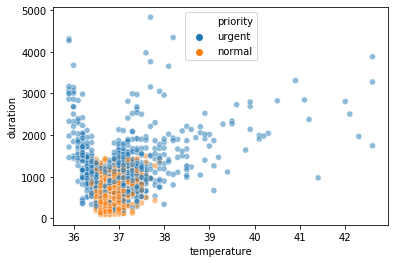

In [6]:
sns.scatterplot(x='temperature', y='duration', data=summary_train_df, hue='priority', alpha=.5);

In [7]:
summary_df['temp_cat'] = pd.cut(summary_df['temperature'],
                                bins=[float('-inf'), 36.5, 37.5, float('inf')],
                                labels=['hypothermia', 'normal', 'fever'])

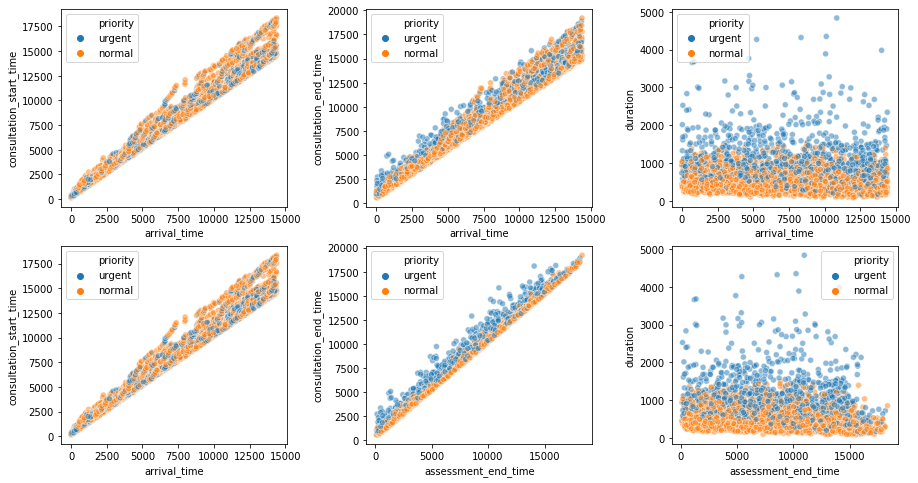

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

sns.scatterplot(x='arrival_time',
                y='consultation_start_time',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[0, 0])
sns.scatterplot(x='arrival_time',
                y='consultation_end_time',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[0, 1])
sns.scatterplot(x='arrival_time',
                y='duration',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[0, 2])

sns.scatterplot(x='arrival_time',
                y='consultation_start_time',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[1, 0])
sns.scatterplot(x='assessment_end_time',
                y='consultation_end_time',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[1, 1])
sns.scatterplot(x='assessment_end_time',
                y='duration',
                data=summary_train_df,
                hue='priority',
                alpha=.5,
                ax=ax[1, 2])

plt.subplots_adjust(wspace=.35);

In [9]:
summary_train_df['consultation_end_time'].describe()

count     3924.000000
mean      8699.954128
std       4423.068498
min        574.000000
25%       4960.000000
50%       8699.500000
75%      12409.500000
max      19202.000000
Name: consultation_end_time, dtype: float64

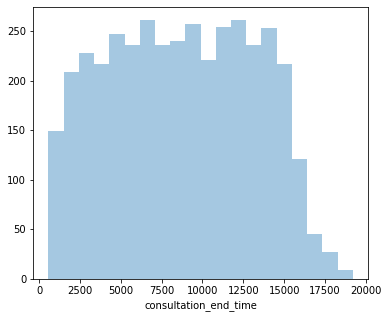

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.distplot(summary_train_df['consultation_end_time'], ax=ax, kde=False);

In [11]:
priority_map = {'normal': 1, 'urgent': 2}
summary_df['priority_enc'] = summary_df['priority'].map(priority_map)

pain_map = {'no pain': 1, 'moderate pain': 2, 'severe pain': 3}
summary_df['pain_enc'] = summary_df['pain'].map(pain_map)

temp_map = {'hypothermia': 2, 'normal': 1, 'fever': 2}
summary_df['temp_cat_enc'] = summary_df['temp_cat'].map(temp_map)

In [12]:
summary_df = pd.get_dummies(summary_df, columns=['pain', 'temp_cat'])

In [13]:
# summary['pain_no pain:temp_cat_hypothermia'] =\
# summary['pain_no pain'] * summary['temp_cat_hypothermia']
# summary['pain_moderate pain:temp_cat_hypothermia'] =\
# summary['pain_moderate pain'] * summary['temp_cat_hypothermia']
summary_df['pain_severe pain:temp_cat_hypothermia'] = \
summary_df['pain_severe pain'] * summary_df['temp_cat_hypothermia']

# summary['pain_no pain:temp_cat_normal'] = summary['pain_no pain'] * summary['temp_cat_normal']
summary_df['pain_moderate pain:temp_cat_normal'] = \
summary_df['pain_moderate pain'] * summary_df['temp_cat_normal']
# summary['pain_severe pain:temp_cat_normal'] = summary['pain_severe pain'] * summary['temp_cat_normal']

# summary['pain_no pain:temp_cat_fever'] = summary['pain_no pain'] * summary['temp_cat_fever']
# summary['pain_moderate pain:temp_cat_fever'] = summary['pain_moderate pain'] * summary['temp_cat_fever']
summary_df['pain_severe pain:temp_cat_fever'] = \
summary_df['pain_severe pain'] * summary_df['temp_cat_fever']

In [14]:
# data000 = summary.loc[summary['pain_no pain:temp_cat_hypothermia'] == 0, 'consultation_end_time']
# data010 = summary.loc[summary['pain_moderate pain:temp_cat_hypothermia'] == 0, 'consultation_end_time']
# data020 = summary.loc[summary['pain_severe pain:temp_cat_hypothermia'] == 0, 'consultation_end_time']
# data001 = summary.loc[summary['pain_no pain:temp_cat_hypothermia'] == 1, 'consultation_end_time']
# data011 = summary.loc[summary['pain_moderate pain:temp_cat_hypothermia'] == 1, 'consultation_end_time']
# data021 = summary.loc[summary['pain_severe pain:temp_cat_hypothermia'] == 1, 'consultation_end_time']

# data100 = summary.loc[summary['pain_no pain:temp_cat_normal'] == 0, 'consultation_end_time']
# data110 = summary.loc[summary['pain_moderate pain:temp_cat_normal'] == 0, 'consultation_end_time']
# data120 = summary.loc[summary['pain_severe pain:temp_cat_normal'] == 0, 'consultation_end_time']
# data101 = summary.loc[summary['pain_no pain:temp_cat_normal'] == 1, 'consultation_end_time']
# data111 = summary.loc[summary['pain_moderate pain:temp_cat_normal'] == 1, 'consultation_end_time']
# data121 = summary.loc[summary['pain_severe pain:temp_cat_normal'] == 1, 'consultation_end_time']

# data200 = summary.loc[summary['pain_no pain:temp_cat_fever'] == 0, 'consultation_end_time']
# data210 = summary.loc[summary['pain_moderate pain:temp_cat_fever'] == 0, 'consultation_end_time']
# data220 = summary.loc[summary['pain_severe pain:temp_cat_fever'] == 0, 'consultation_end_time']
# data201 = summary.loc[summary['pain_no pain:temp_cat_fever'] == 1, 'consultation_end_time']
# data211 = summary.loc[summary['pain_moderate pain:temp_cat_fever'] == 1, 'consultation_end_time']
# data221 = summary.loc[summary['pain_severe pain:temp_cat_fever'] == 1, 'consultation_end_time']

# fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# sns.distplot(data000, ax=ax[0, 0], kde=False)
# sns.distplot(data010, ax=ax[0, 1], kde=False)
# sns.distplot(data020, ax=ax[0, 2], kde=False)
# sns.distplot(data001, ax=ax[0, 0], kde=False)
# sns.distplot(data011, ax=ax[0, 1], kde=False)
# sns.distplot(data021, ax=ax[0, 2], kde=False)
# sns.distplot(data100, ax=ax[1, 0], kde=False)
# sns.distplot(data110, ax=ax[1, 1], kde=False)
# sns.distplot(data120, ax=ax[1, 2], kde=False)
# sns.distplot(data101, ax=ax[1, 0], kde=False)
# sns.distplot(data111, ax=ax[1, 1], kde=False)
# sns.distplot(data121, ax=ax[1, 2], kde=False)
# sns.distplot(data200, ax=ax[2, 0], kde=False)
# sns.distplot(data210, ax=ax[2, 1], kde=False)
# sns.distplot(data220, ax=ax[2, 2], kde=False)
# sns.distplot(data201, ax=ax[2, 0], kde=False)
# sns.distplot(data211, ax=ax[2, 1], kde=False)
# sns.distplot(data221, ax=ax[2, 2], kde=False)

# plt.subplots_adjust(wspace=.25);

In [15]:
summary.head()

Unnamed: 0  arrival_time  assessment_end_time  assessment_start_time  \
0        1830            22                  113                     53   
1        4220            22                  113                     49   
2         822             8                  131                     39   
3         386            20                  138                     55   
4        4321            52                  161                     89   

   consultation_end_time  consultation_start_time  day  duration  \
0                    593                      137   24       456   
1                    749                      193   49       556   
2                   1106                      169   12       937   
3                    574                      164    6       410   
4                    999                      208   50       790   

            pain  patient priority  temperature  
0        no pain     1831   normal         36.7  
1        no pain     4220   normal         36.8  
2  moderate pain      820   urgent         37.3  
3        no pain      387   normal         36.7  
4  moderate pain     4322   urgent         37.1

In [16]:
# def create_new_features(df):
#     '''
#     Given a dataframe, returns dataframe with added new features:
#         free_doctors: number of doctors available after patient has passed triage
#         queue_size: queue size after patient has passed triage
#         urgents_on_queue: number of urgent priority patients on queue after patient has passed triage
#     '''
    
#     free_docs = [6]
#     q_urg = [list()]
#     q_norm = [list()]
#     q_real = [list()]
#     urgs_on_q = [0]
#     q_size = 0
#     nonbusy_docs = 0
#     consult_endtime_ls = [df.loc[0, 'consultation_end_time']]
    
#     for i in range(1, len(df)):
#         nonbusy_docs = (df.loc[i, 'assessment_end_time'] >= consult_endtime_ls).sum()
#         consult_endtime_ls = consult_endtime_ls[nonbusy_docs:]

#         if free_docs[i - 1] > 1:
#             free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
#             consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
#             consult_endtime_ls = sorted(consult_endtime_ls)
#             q_urg.append(q_urg[i - 1])
#             q_norm.append(q_norm[i - 1])
#             q_real.append(q_urg[i] + q_norm[i])
#             urgs_on_q.append(urgs_on_q[i - 1])
#         elif nonbusy_docs == 0:
#             free_docs.append(0)
#             if df.loc[i, 'priority'] == 'urgent':
#                 urgs_on_q.append(urgs_on_q[i - 1] + 1)
#                 q_urg.append(q_urg[i - 1] + [i])
#                 q_norm.append(q_norm[i - 1])
#             else:
#                 urgs_on_q.append(urgs_on_q[i - 1])
#                 q_urg.append(q_urg[i - 1])
#                 q_norm.append(q_norm[i - 1] + [i])
#             q_real.append(q_urg[i] + q_norm[i])
#             q_size = len(q_real[i])
#         elif q_size == 0:
#             free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
#             q_urg.append(q_urg[i - 1])
#             q_norm.append(q_norm[i - 1])
#             q_real.append(q_urg[i] + q_norm[i])
#             urgs_on_q.append(urgs_on_q[i - 1])
#             consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
#             consult_endtime_ls = sorted(consult_endtime_ls)
#         else:
#             free_docs.append(np.max([free_docs[i - 1] + nonbusy_docs - q_size, 0]))
#             if df.loc[i, 'priority'] == 'urgent':
#                 urgs_on_q.append(urgs_on_q[i - 1] + 1)
#                 q_urg.append(q_urg[i - 1] + [i])
#                 q_norm.append(q_norm[i - 1])
#             else:
#                 urgs_on_q.append(urgs_on_q[i - 1])
#                 q_urg.append(q_urg[i - 1])
#                 q_norm.append(q_norm[i - 1] + [i])
#             q_real.append(q_urg[i] + q_norm[i])
#             q_size = len(q_real[i])
#             while q_size > 0 and nonbusy_docs > 0:
#                 patient = q_real[i].pop(0)
#                 if df.loc[patient, 'priority'] == 'urgent':
#                     urgs_on_q[i] -= 1
#                     q_urg[i].pop(0)
#                 else:
#                     q_norm[i].pop(0)
#                 consult_endtime_ls.append(df.loc[patient, 'consultation_end_time'])
#                 consult_endtime_ls = sorted(consult_endtime_ls)
#                 q_size -= 1
#                 nonbusy_docs -= 1
                
# #     new_features = pd.DataFrame([free_docs, pd.Series(q_real).apply(lambda x: len(x)), urgs_on_q],
# #                                 index=['free_doctors', 'queue_size', 'urgents_on_queue']).T
    
#     new_features = pd.DataFrame([pd.Series(q_real).apply(lambda x: len(x))],
#                             index=['queue_size']).T
    
#     return pd.concat([df, new_features], axis=1)

In [17]:
# summary_new = pd.DataFrame(columns=summary.columns)
# for i in summary['day'].unique():
#     df = create_new_features(summary[summary['day'] == i].reset_index(drop=True))
#     summary_new = pd.concat([summary_new, df], axis=0)

cols_to_drop = ['Unnamed: 0', 'arrival_time', 'assessment_start_time', 'patient',
                'priority', 'temperature', 'consultation_start_time',
                'pain_no pain', 'pain_moderate pain', 'pain_severe pain',
                'temp_cat_hypothermia', 'temp_cat_normal', 'temp_cat_fever']

summary_df.drop(cols_to_drop, axis=1, inplace=True)

In [18]:
df_train = summary_df[summary_df['day'] <= 45]
df_test = summary_df[summary_df['day'] > 45]

In [19]:
best_params_ls = []
train_error_ls = []
val_error_ls = []

def get_best_params_and_errors(df):
    '''
    Given df, returns:
        - a list of the parameters of the best model for each day
        - a list of the cv train rmse of the best model for each day
        - a list of the cv validation rmse of the best model for each day
    '''
    
    for i in tqdm(df['day'].unique()):
        X_train = df[df['day'] == i].drop(['day', 'duration'], axis=1)
        y_train = df.loc[df['day'] == i, 'duration']

        tscv = TimeSeriesSplit(n_splits=5)

        ridge = Ridge(normalize=True, random_state=42)
        ridge_params = {'alpha': ss.uniform(0, 6)}

        rscv = RandomizedSearchCV(ridge,
                                  ridge_params,
                                  n_iter=100,
                                  scoring=make_scorer(mean_squared_log_error, greater_is_better=False),
                                  n_jobs=-1,
                                  cv=tscv,
                                  verbose=1,
                                  random_state=42,
                                  return_train_score=True)

        rscv.fit(X_train, y_train)

        best_params_ls.append(rscv.best_params_)

        cv_results = pd.DataFrame(rscv.cv_results_)
        train_error_ls.append(np.sqrt(-cv_results.loc[rscv.best_index_, 'mean_train_score']))
        val_error_ls.append(np.sqrt(-cv_results.loc[rscv.best_index_, 'mean_test_score']))
        
    return best_params_ls, train_error_ls, val_error_ls

In [20]:
best_params_ls, train_error_ls, val_error_ls = get_best_params_and_errors(df_train)

results_train_df = pd.DataFrame([best_params_ls, train_error_ls, val_error_ls],
                                 index=['best_params', 'train_rmse', 'val_rmse']).T

  0%|          | 0/45 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished
  2%|▏         | 1/45 [00:02<01:57,  2.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
  4%|▍         | 2/45 [00:03<01:28,  2.06s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
  7%|▋         | 3/45 [00:03<01:08,  1.63s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
  9%|▉         | 4/45 [00:04<00:54,  1.33s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 11%|█         | 5/45 [00:05<00:44,  1.11s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 13%|█▎        | 6/45 [00:05<00:37,  1.04it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 16%|█▌        | 7/45 [00:06<00:34,  1.09it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 18%|█▊        | 8/45 [00:07<00:32,  1.13it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 20%|██        | 9/45 [00:08<00:31,  1.14it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 22%|██▏       | 10/45 [00:09<00:30,  1.16it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 24%|██▍       | 11/45 [00:09<00:29,  1.17it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 27%|██▋       | 12/45 [00:10<00:28,  1.18it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 29%|██▉       | 13/45 [00:11<00:27,  1.18it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 31%|███       | 14/45 [00:12<00:26,  1.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 33%|███▎      | 15/45 [00:13<00:25,  1.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 36%|███▌      | 16/45 [00:14<00:24,  1.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 38%|███▊      | 17/45 [00:14<00:23,  1.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 40%|████      | 18/45 [00:15<00:22,  1.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 42%|████▏     | 19/45 [00:16<00:21,  1.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 44%|████▍     | 20/45 [00:17<00:20,  1.21it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 47%|████▋     | 21/45 [00:18<00:19,  1.22it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 49%|████▉     | 22/45 [00:18<00:18,  1.23it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 51%|█████     | 23/45 [00:19<00:17,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 53%|█████▎    | 24/45 [00:20<00:16,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 56%|█████▌    | 25/45 [00:21<00:16,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 58%|█████▊    | 26/45 [00:22<00:15,  1.26it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 60%|██████    | 27/45 [00:22<00:14,  1.26it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 62%|██████▏   | 28/45 [00:23<00:13,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 64%|██████▍   | 29/45 [00:24<00:12,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 67%|██████▋   | 30/45 [00:25<00:11,  1.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 69%|██████▉   | 31/45 [00:26<00:11,  1.24it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 71%|███████   | 32/45 [00:27<00:10,  1.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 73%|███████▎  | 33/45 [00:28<00:10,  1.15it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 76%|███████▌  | 34/45 [00:28<00:09,  1.13it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
 78%|███████▊  | 35/45 [00:29<00:09,  1.08it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 80%|████████  | 36/45 [00:30<00:08,  1.09it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 82%|████████▏ | 37/45 [00:31<00:07,  1.09it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 84%|████████▍ | 38/45 [00:32<00:06,  1.09it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
 87%|████████▋ | 39/45 [00:33<00:05,  1.09it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 89%|████████▉ | 40/45 [00:34<00:04,  1.11it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 91%|█████████ | 41/45 [00:35<00:03,  1.15it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 93%|█████████▎| 42/45 [00:36<00:02,  1.17it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 96%|█████████▌| 43/45 [00:36<00:01,  1.21it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 98%|█████████▊| 44/45 [00:37<00:00,  1.22it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


In [21]:
class MetaEstimator():
    def __init__(self, best_params):
        self.best_params = best_params
            
    def fit(self, X, y):
        days = X['day'].unique()
        X_ls = [X[X['day'] == i] for i in days]
        y_ls = [y[y['day'] == i] for i in days]
        
        best_estimator_ls = []
        for i in range(len(self.best_params)):
            params = self.best_params[i]
            ridge = Ridge(normalize=False, random_state=42, **params)
            X = X_ls[i].drop('day', axis=1)
            y = y_ls[i].drop('day', axis=1)
            best_estimator_ls.append(ridge.fit(X, y))
            
        self.estimators_ls = best_estimator_ls
        
        intercept = 0
        coef = np.zeros_like(self.estimators_ls[0].coef_)
        for estimator in self.estimators_ls:
            intercept += estimator.intercept_
            coef += estimator.coef_
        n_estimators = len(self.estimators_ls)
        
        self.coefs = np.append(intercept, coef[0]) / n_estimators
    
    def predict(self, X):
        days = X['day'].unique()
        X_ls = [X[X['day'] == i] for i in days]

        preds = np.empty(0)
        for i in range(len(X_ls)):
            C = pd.Series(np.ones(len(X_ls[i])), name='C', index=X_ls[i].index)
            X_new = pd.concat([C, X_ls[i]], axis=1).drop('day', axis=1)
            preds = np.append(preds, X_new @ self.coefs)
        return preds

In [22]:
scaler = StandardScaler()

df_train_new = df_train.drop(['day', 'consultation_end_time', 'duration'], axis=1)
df_test_new = df_test.drop(['day', 'consultation_end_time', 'duration'], axis=1)

X_train_scaled = \
pd.concat([pd.DataFrame(scaler.fit_transform(df_train_new), columns=df_train_new.columns),
           df_train['day']], axis=1)
X_test_scaled = \
pd.concat([pd.DataFrame(scaler.transform(df_test_new), columns=df_test_new.columns, index=df_test_new.index),
           df_test['day']], axis=1)

y_train = df_train[['day', 'consultation_end_time']]
y_test = df_test[['day', 'consultation_end_time']]

meta = MetaEstimator(results_train_df['best_params'])
meta.fit(X_train_scaled, y_train)

In [23]:
X_train_scaled

assessment_end_time  priority_enc  pain_enc  temp_cat_enc  \
0               -1.644707      1.594213 -0.727148     -0.382574   
1               -1.619848     -0.627269  1.900227     -0.382574   
2               -1.573746     -0.627269  1.900227     -0.382574   
3               -1.531033      1.594213  1.900227     -0.382574   
4               -1.506852      1.594213  1.900227      2.613874   
...                   ...           ...       ...           ...   
3919             2.134795     -0.627269  0.586539     -0.382574   
3920             2.156264      1.594213  0.586539     -0.382574   
3921             2.181802     -0.627269  0.586539     -0.382574   
3922             2.206435     -0.627269  0.586539     -0.382574   
3923             2.233102     -0.627269  0.586539     -0.382574   

      pain_severe pain:temp_cat_hypothermia  \
0                                 -0.216699   
1                                 -0.216699   
2                                 -0.216699   
3                                 -0.216699   
4                                  4.614700   
...                                     ...   
3919                              -0.216699   
3920                              -0.216699   
3921                              -0.216699   
3922                              -0.216699   
3923                              -0.216699   

      pain_moderate pain:temp_cat_normal  pain_severe pain:temp_cat_fever  day  
0                               -0.48530                        -0.171409    1  
1                               -0.48530                        -0.171409    1  
2                               -0.48530                        -0.171409    1  
3                               -0.48530                        -0.171409    1  
4                               -0.48530                        -0.171409    1  
...                                  ...                              ...  ...  
3919                             2.06058                        -0.171409   45  
3920                             2.06058                        -0.171409   45  
3921                             2.06058                        -0.171409   45  
3922                             2.06058                        -0.171409   45  
3923                             2.06058                        -0.171409   45  

[3924 rows x 8 columns]

In [24]:
y_test_true = df_test['consultation_end_time'] - df_test['assessment_end_time']
y_test_pred = meta.predict(X_test_scaled) - df_test['assessment_end_time']

train_error = np.sqrt(results_train_df['train_rmse'].mean())
val_error = np.sqrt(results_train_df['val_rmse'].mean())
test_error = np.sqrt(mean_squared_log_error(y_test_true, y_test_pred))

print(f'train root mean squared log error: {train_error}')
print(f'val root mean squared log error: {val_error}')
print(f'test root mean squared log error: {test_error}')

train root mean squared log error: 0.5685293320859324
val root mean squared log error: 0.6671920554873103
test root mean squared log error: 0.46989668802218304


In [25]:
coefs_df = pd.DataFrame(list(zip(np.append('C', X_train_scaled.columns), meta.coefs)),
                        columns=['feature', 'coef'])

In [26]:
coefs_df['coef_abs'] = coefs_df['coef'].abs()
coefs_df.sort_values('coef_abs', ascending=False).reset_index(drop=True)

feature         coef     coef_abs
0                                      C  8715.754767  8715.754767
1                    assessment_end_time  4397.299899  4397.299899
2                               pain_enc   143.452854   143.452854
3                           priority_enc   111.496609   111.496609
4        pain_severe pain:temp_cat_fever    94.040078    94.040078
5  pain_severe pain:temp_cat_hypothermia    77.279200    77.279200
6                           temp_cat_enc    61.094210    61.094210
7     pain_moderate pain:temp_cat_normal   -31.788882    31.788882

In [27]:
df = summary_df.drop(['day', 'consultation_end_time', 'duration'], axis=1)

X = pd.concat([pd.DataFrame(scaler.fit_transform(df), columns=df.columns),
               summary_df['day']], axis=1)

y = summary_df[['day', 'consultation_end_time']]

meta = MetaEstimator(results_train_df['best_params'])
meta.fit(X, y)

In [35]:
y_true = summary_df['consultation_end_time'] - summary_df['assessment_end_time']
y_pred = meta.predict(X) - summary_df['assessment_end_time']

overall_error = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f'overall root mean squared log error: {overall_error}')

overall root mean squared log error: 0.44593056789484664
